In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import rawpy as raw
import time
from mpl_toolkits.mplot3d import Axes3D
from peakutils import peak
from scipy import integrate, interpolate as interp, signal as sig, \
                  stats as stat, fftpack as fft
from jupyterthemes import jtplot

In [3]:
jtplot.reset()
# plt.switch_backend('nbAgg')
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}", r"\usepackage{url}"]

In [4]:
class ROISelect:
    def __init__(self, image):
        self.image = image
        self.cropping = False
        self.sel_rect_endpoint = None
        self.refpt = None
        
    def ColorPicker(self, event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            self.refpt = [(x, y)]
            self.cropping = True

        elif event == cv.EVENT_LBUTTONUP:
            self.refpt.append((x, y))
            self.cropping = False

            cv.rectangle(self.image, self.refpt[0], self.refpt[1], (0, 255, 0), 2)
            cv.imshow('select ROI', self.image)

        elif event == cv.EVENT_MOUSEMOVE and self.cropping:
            self.sel_rect_endpoint = [(x, y)]

    def get_ROI(self):
        image = (self.image/self.image.max()).astype('float32')
        clone = image.copy()
        cv.namedWindow('select ROI', cv.WINDOW_NORMAL)
        if image.shape[0] > image.shape[1]:
            cv.resizeWindow('select ROI', 400, 600)
        else:
            cv.resizeWindow('select ROI', 600, 400)
        cv.setMouseCallback('select ROI', self.ColorPicker)

        while True:
            if not self.cropping:
                cv.imshow('select ROI', self.image)
            elif self.cropping and self.sel_rect_endpoint:
                rect_cpy = image.copy()
                cv.rectangle(rect_cpy, self.refpt[0], self.sel_rect_endpoint[0], (0, 255, 0), 1)
                cv.imshow('select ROI', rect_cpy)

            key = cv.waitKey(1) & 0xFF
            if key == ord('r'):
                image = clone.copy()

            elif key == ord('c'):
                break

        if len(self.refpt) == 2:
            self.roi = clone[self.refpt[0][1]:self.refpt[1][1], self.refpt[0][0]:self.refpt[1][0]]
            cv.namedWindow('ROI', cv.WINDOW_NORMAL)
            cv.imshow("ROI", self.roi)
            cv.waitKey(0)

        cv.destroyAllWindows()
        return self.roi

In [232]:
class MeasureMTF:
    def __init__(self, params_dict, plot=False, save=False):
        file = params_dict['file']
        if type(file) == str:
            img_raw = raw.imread(file)
            img = img_raw.postprocess(use_camera_wb=True,
                                      output_bps=8,
                                      no_auto_bright=True)
            self.image = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
            self.filename = file.split('/')[-1].split('.')[0][4:]
        elif type(file) == np.ndarray:
            self.image = file
        else:
            raise NotImplementedError
        self.name = params_dict['name']
        self.rot = params_dict['rot']
        self.bbox = params_dict['bbox']
        self.len_px = params_dict['len_px']
        
        if plot:
            plt.imshow(self.image, 'gray')
            plt.grid(0)
            plt.tight_layout()
            if save and type(file) == str:
                plt.savefig(self.filename + '_gray.png', dpi=300, bbox_inches='tight')
            plt.show()
            
    def selectROI(self, show=False, save=False):
        rois = ROISelect(self.image)
        self.roi = rois.get_ROI()
        self.droi_dx = np.gradient(self.roi)
        self.droi_dx = np.hypot(self.droi_dx[0], self.droi_dx[1])
        
        if show:
            fig, ax = plt.subplots(1, 2, figsize=(16/2, 9/2))
            ax[0].imshow(self.roi, 'gray', vmin=self.roi.min(), vmax=self.roi.max())
            ax[0].grid(0)
            ax[0].set_title('ROI')
            ax[1].imshow(self.droi_dx, 'gray')
            ax[1].grid(0)
            ax[1].set_title(r'$\dv{}{x}\mathrm{ROI}$')
            
            plt.tight_layout()
            if save:
                plt.savefig(self.filename + '_deriv.png', dpi=300, bbox_inches='tight')
            plt.show()
            
    def straighten(self, show=False, save=False):
        h,w = self.roi.shape
        M = cv.getRotationMatrix2D((w//2, h//2), self.rot, 1.0)
        roi_rot = cv.warpAffine(self.roi, M, (self.roi.shape))
        
        t, b, l, r = self.bbox
        self.roi_croprot = roi_rot[t:b, l:r]
        
        if show:
            fig, ax = plt.subplots(1, 2, figsize=(16/2, 9/2))
            ax[0].imshow(self.roi_croprot, 'gray', vmin=self.roi.min(), vmax=self.roi.max())
            ax[0].grid(0)
            ax[0].set_title('straightened ROI')
            ax[1].imshow(abs(fft.fftshift(fft.fft(self.roi_croprot))), 'hot')
            ax[1].grid(0)
            ax[1].set_title('ROI FT')
            
            plt.tight_layout()
            if save:
                plt.savefig(self.filename + '_roi.png', dpi=300, bbox_inches='tight')
            plt.show()
            
    def project(self, show=False, save=False):
        roi_hproj = self.roi_croprot.mean(axis=0)
        roi_hproj /= roi_hproj.max()
        roi_lsf = np.gradient(roi_hproj)
        roi_lsf /= roi_lsf.max()
        self.roi_lsf = roi_lsf
        
        if show:
            plt.plot(roi_hproj, lw=1)
            plt.plot(roi_lsf, lw=1)
            plt.legend(['ESF', 'LSF'])
            plt.tight_layout()
            if save:
                plt.savefig(self.filename + '_sf.png', dpi=300, bbox_inches='tight')
            plt.show()
            
    def calcMTF(self, len_mm=133, show=False, save=False):
        self.px2mm = lambda px: px * len_mm/self.len_px
        N = len(self.roi_lsf)
        self.mtf = abs(fft.fft(self.roi_lsf))[:N//2]
        self.mtf /= self.mtf.max()
        cpx = np.linspace(0, 1, self.mtf.size)
        mtf50 = cpx[np.argmin(abs(0.5 - self.mtf))]
        lpm_factor = mtf50/(23.5/6000)
        lpm = cpx * lpm_factor
        self.mtf50 = lpm[np.argmin(abs(0.5 - self.mtf))]
        
        if show:
            plt.plot(lpm, self.mtf, label=r'$\mathrm{MTF50 = %i}$ lp/mm' %(np.round(self.mtf50)))
            plt.xlabel('lp/mm')
            plt.ylabel('MTF')
            plt.title(self.name)
            plt.legend()
            plt.tight_layout()
            if save:
                plt.savefig(self.filename + '_mtf.png', dpi=300, bbox_inches='tight')
            plt.show()
            
    def main(self, len_mm=113, show=False, save=False):
        self.selectROI(show, save)
        self.straighten(show, save)
        self.project(show, save)
        self.calcMTF(len_mm, show, save)

In [233]:
prep_dict = dict({ 'file': ['raw/_KVD7149.NEF', 'raw/_KVD7150.NEF', 'raw/_KVD7153.NEF', 'raw/_KVD7155.NEF'],
                   'name': ['Nikon D3400 + SIGMA 24-70mm@70, f/2.8', 'Nikon D3400 + NIKKOR 70-300@70, f/4.5',
                            'Nikon D3400 + NIKKOR 50mm, f/2.8', 'Nikon D3400 + NIKKOR 18-55mm@35, f/4.5'],
                   'rot': 49.5+180,
                   'bbox': (1000, 2000, 500, 2000),
                   'len_px': [4324-1541, 4455 - 1533, 4120 - 1244, 4345 - 1573]
                  })

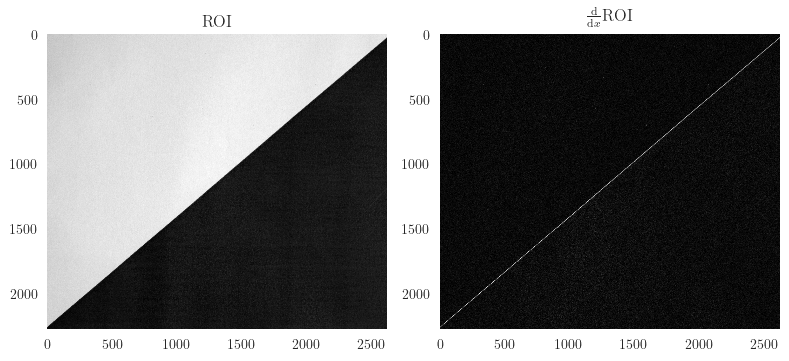

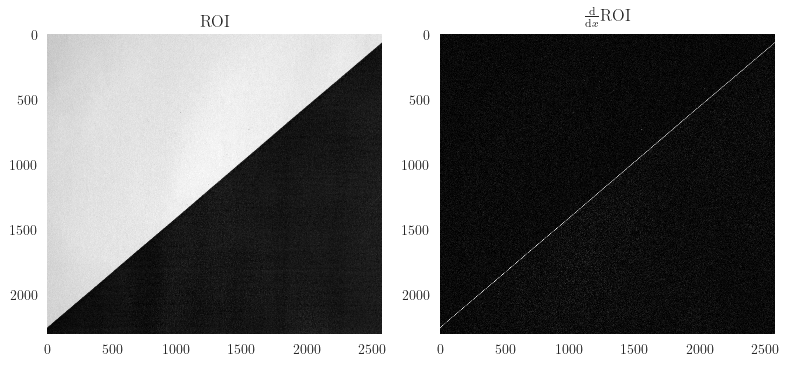

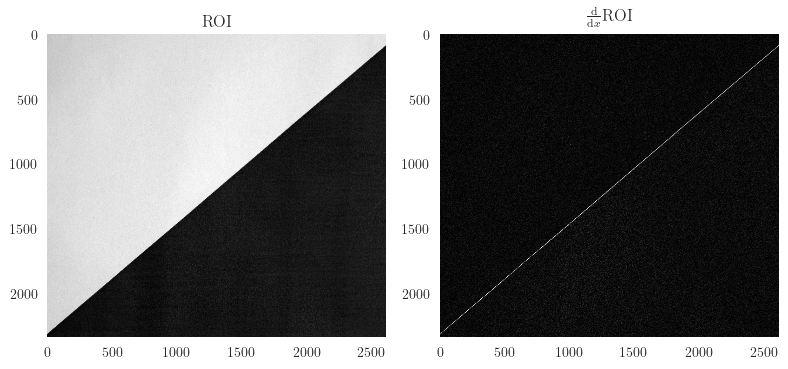

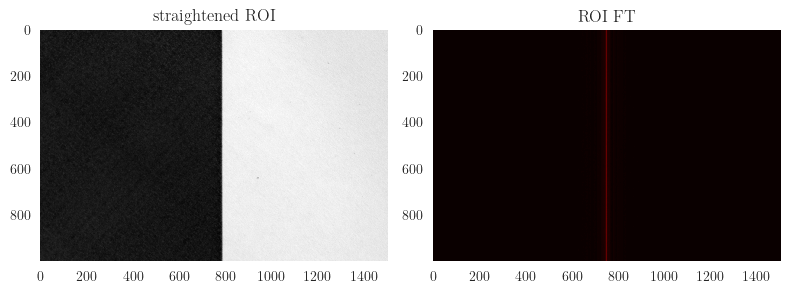

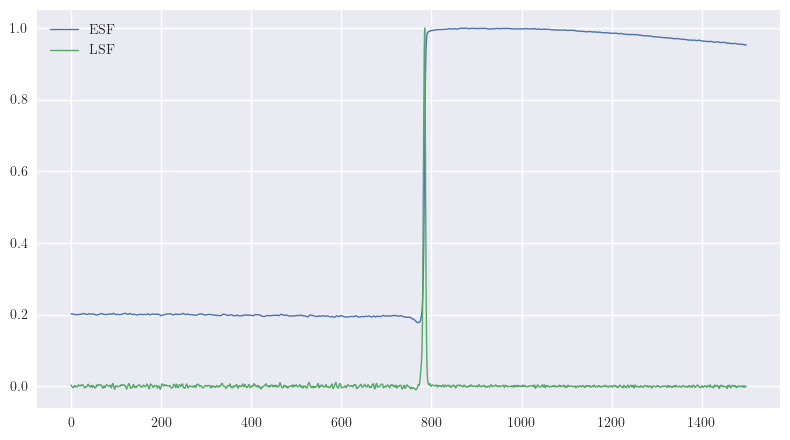

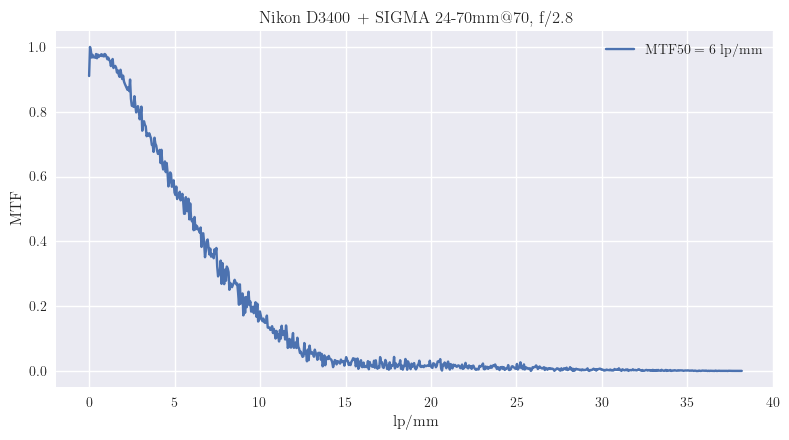

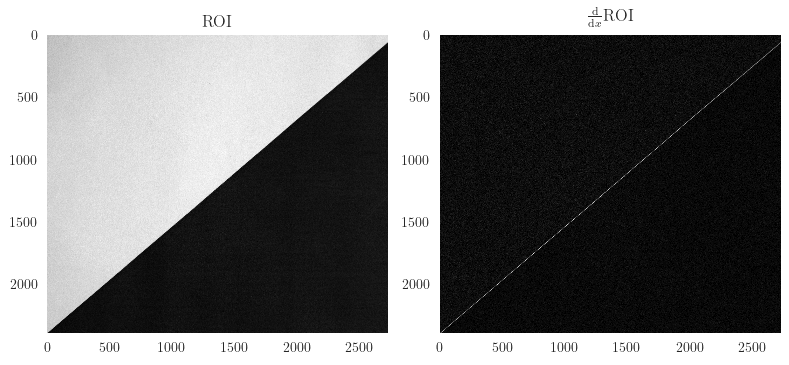

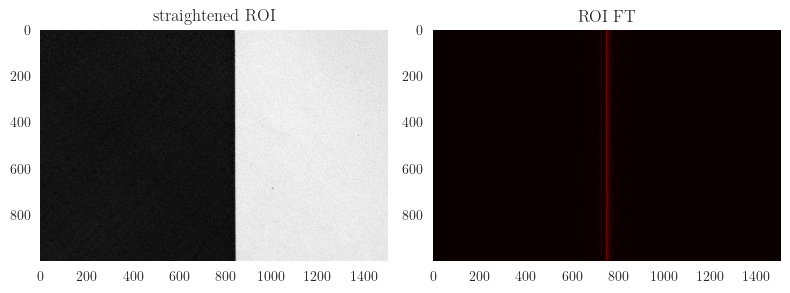

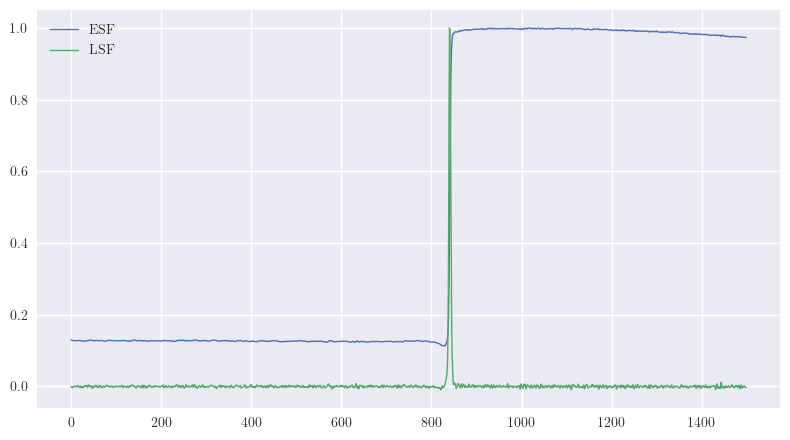

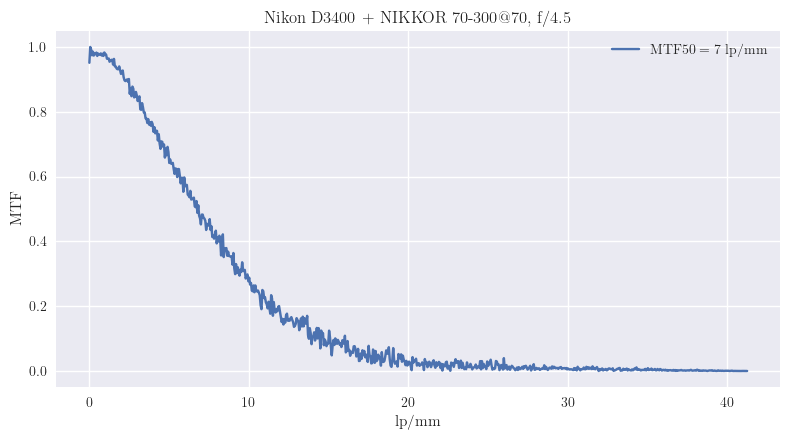

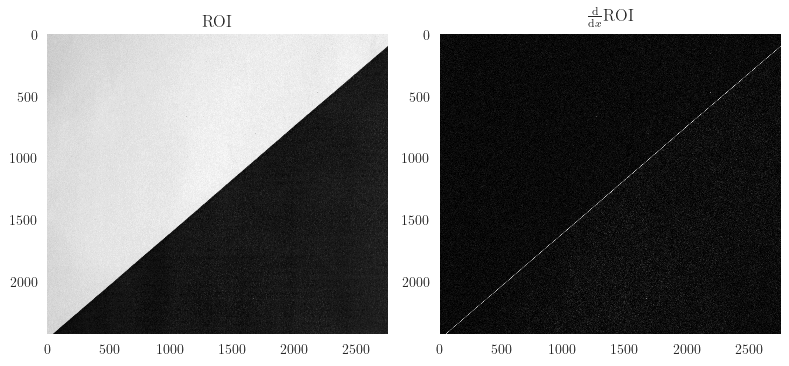

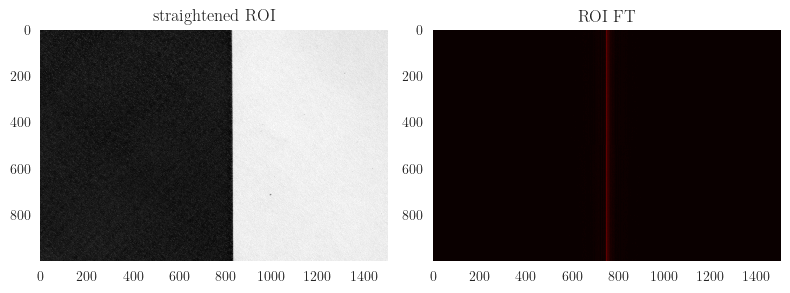

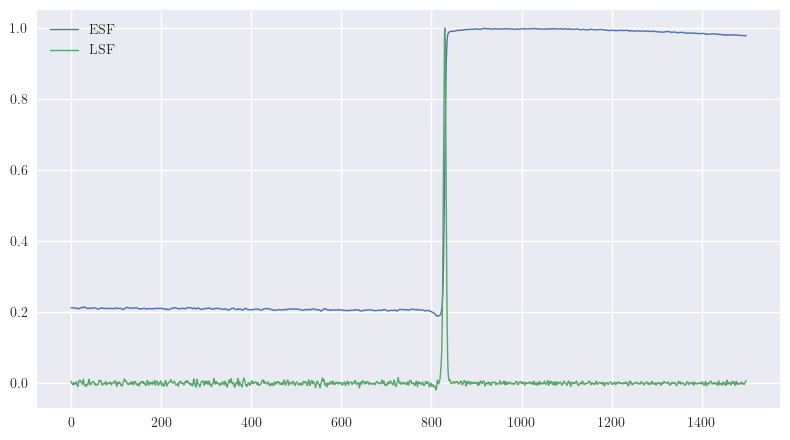

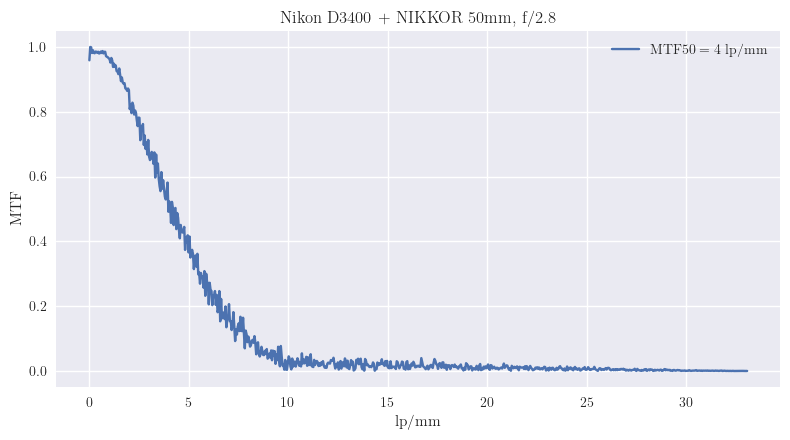

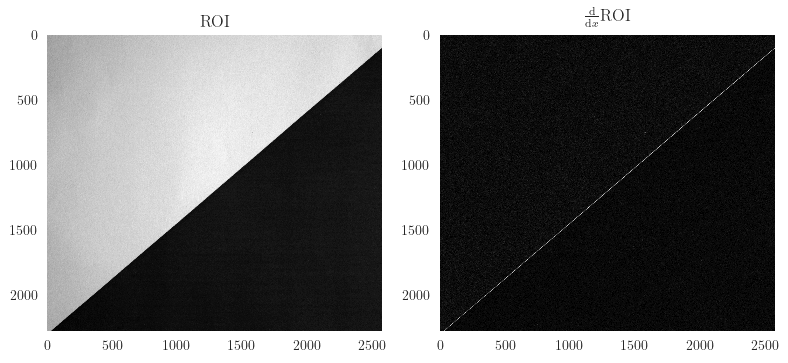

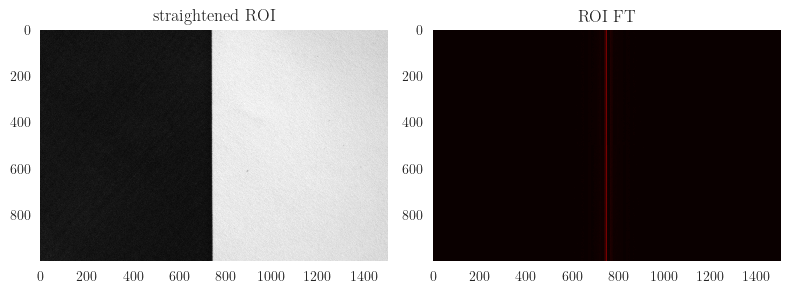

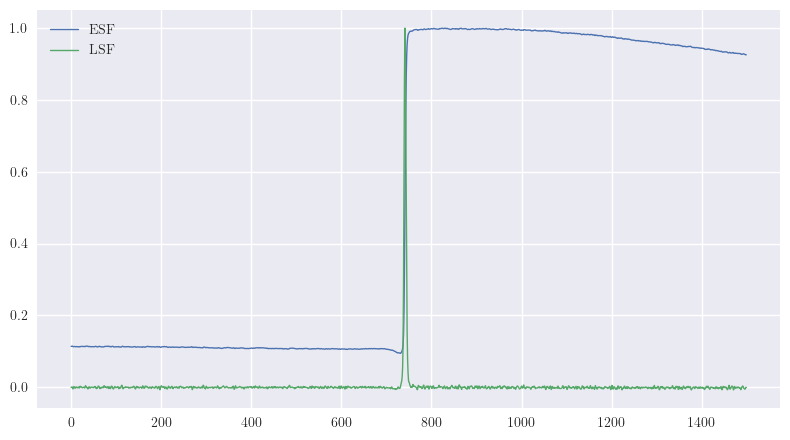

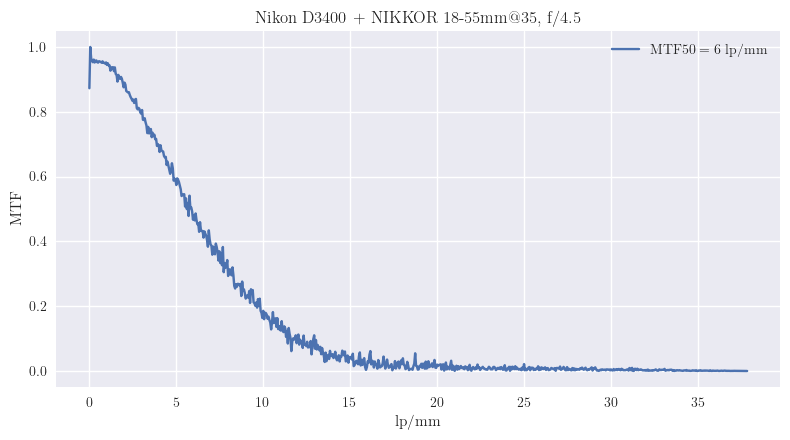

In [234]:
for i in range(len(prep_dict['file'])):
    params_dict = dict({'file': prep_dict['file'][i],
                        'name': prep_dict['name'][i],
                        'rot' : prep_dict['rot'],
                        'bbox': prep_dict['bbox'],
                        'len_px': prep_dict['len_px'][i]
                       })
    cal = MeasureMTF(params_dict)
    cal.main(show=True, save=True)